 특정 시간대의 단속 강화로 인해 사고 발생률이 어떻게 변하는지,

 그리고 이로 인해 전체 사고 발생률이 얼마나 감소하는지를 분석하는 데 중점

 각 시나리오에서의 결과를 분석하는 기법

 이번 시뮬레이션에서는 시간대별 단속 강화가 사고 발생률에 미치는 영향을 평가하기 위해 가중치를 조정하여 시뮬레이션을 수행

##1.패키지 불러옴

In [ ]:
# 한글 불러옴
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (29.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123576 files and direc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Google Colab에서 드라이브 마운트
from google.colab import drive

# 기타 유용한 패키지 import
import os
import datetime
import time

# 나눔고딕 폰트 설정
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rc('font', family='NanumGothic')

##데이터셋 생성

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/[통계청 공모전] 음주운전/1 데이터/전처리 데이터/0서울경찰별 단속신상정보.csv')

In [ ]:
df.head()

,성별,적발횟수,나이,알콜농도,측정일시,관할경찰서,연령대,측정일,측정월,측정요일,측정시간
11,여자,1,61.0,0.096,2022-01-01 03:48:00,서울강동경찰서,60대,2022-01-01,1,Saturday,3
36,남자,1,26.0,0.094,2022-01-02 00:14:00,서울강동경찰서,20대,2022-01-02,1,Sunday,0
43,남자,1,47.0,0.038,2022-01-02 03:10:00,서울강동경찰서,40대,2022-01-02,1,Sunday,3
75,남자,1,37.0,0.120,2022-01-03 19:17:00,서울강동경찰서,30대,2022-01-03,1,Monday,19
78,남자,1,35.0,0.226,2022-01-03 20:33:00,서울강동경찰서,30대,2022-01-03,1,Monday,20


In [ ]:
df = df[df['관할경찰서'].str.contains('강동')]

In [ ]:
df['적발횟수'] = 1

In [ ]:
# 측정일별로 적발횟수 합산
daily_accidents = df.groupby('측정일')['적발횟수'].sum().reset_index()
daily_accidents['측정일'] = pd.to_datetime(daily_accidents['측정일'])
daily_accidents.set_index('측정일', inplace=True)

# 실제 데이터
actual_data = daily_accidents['적발횟수'].values

In [ ]:
daily_accidents

,적발횟수
측정일,
2022-01-01,1
2022-01-02,2
2022-01-03,2
2022-01-05,1
2022-01-06,1
...,...
2022-12-27,2
2022-12-28,2
2022-12-29,3


In [ ]:
# 시뮬레이션 진행
simulated_accidents = daily_accidents.copy()

# 토요일 값 20% 감소
saturdays = simulated_accidents.index.dayofweek == 5
simulated_accidents.loc[saturdays, '적발횟수'] *= np.random.choice([0.8, 1], size=saturdays.sum(), p=[0.7, 0.3])

# 감소된 총 건수 계산
total_decrease = daily_accidents['적발횟수'].sum() - simulated_accidents['적발횟수'].sum()

# 감소된 총 건수 출력
print(f"총 감소된 적발횟수: {total_decrease}건")

총 감소된 적발횟수: 15.0건


In [ ]:
daily_accidents['적발횟수'].sum()

524

In [ ]:
simulated_accidents['적발횟수'].sum()

505.6

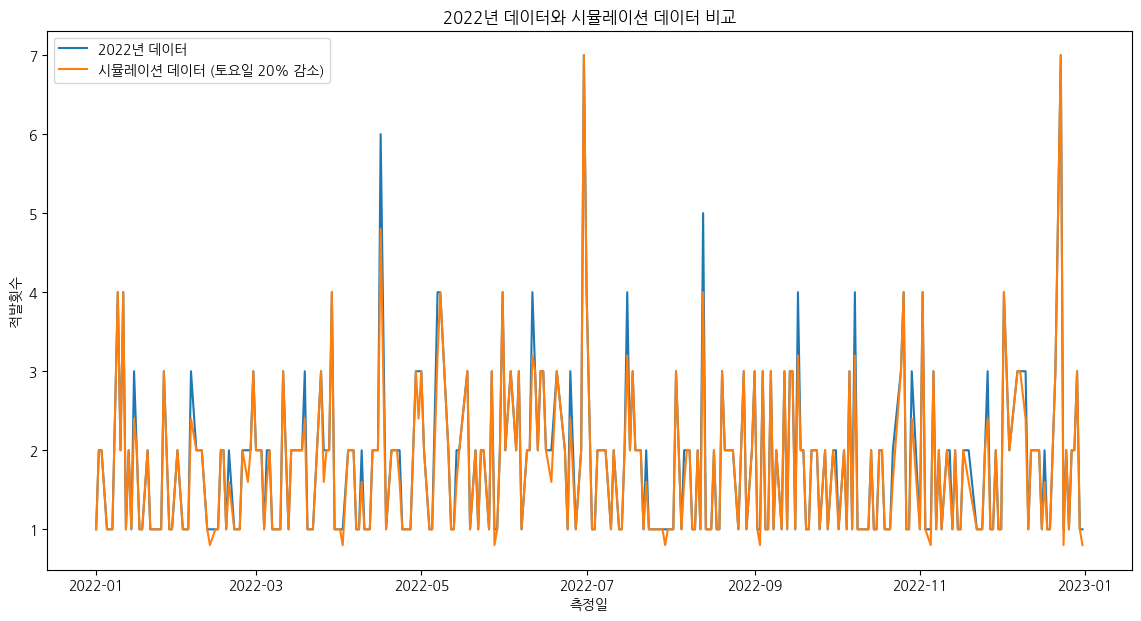

In [ ]:
# 라인 차트 그리기
plt.figure(figsize=(14, 7))
plt.plot(daily_accidents.index, daily_accidents['적발횟수'], label='2022년 데이터')
plt.plot(simulated_accidents.index, simulated_accidents['적발횟수'], label='시뮬레이션 데이터 (토요일 20% 감소)')
plt.xlabel('측정일')
plt.ylabel('적발횟수')
plt.title('2022년 데이터와 시뮬레이션 데이터 비교')
plt.legend()
plt.show()

확률조정

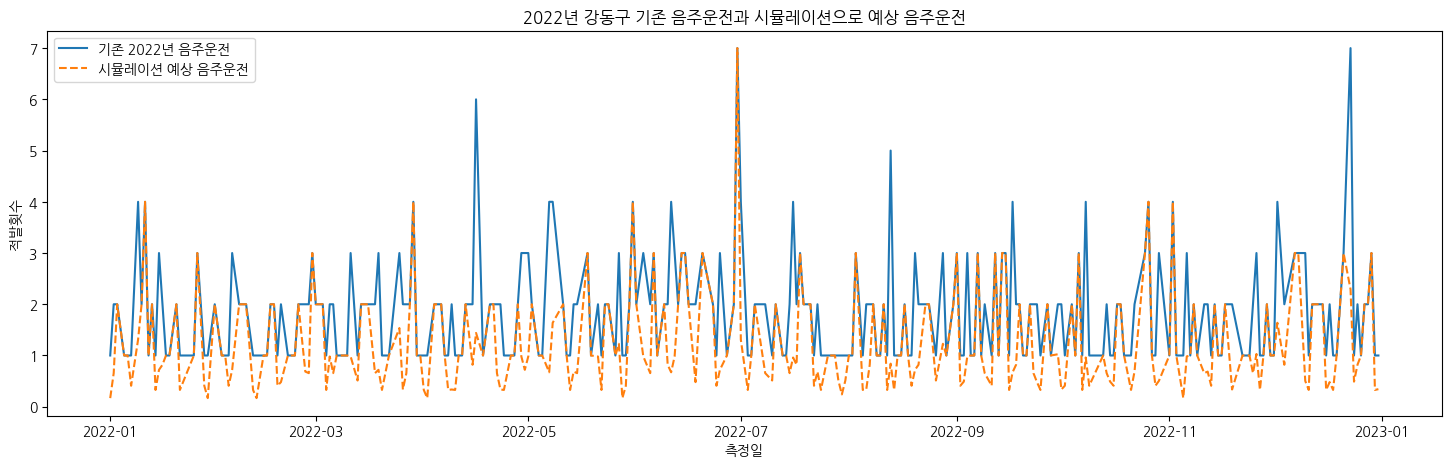

기존 데이터 총 적발 횟수: 524건
시뮬레이션 데이터 총 적발 횟수: 352.15705건
총 감소된 적발 횟수: 171.84294999999997건


In [ ]:

# 금요일, 일요일, 토요일 값 감소
fridays = simulated_accidents.index.dayofweek == 4
sundays = simulated_accidents.index.dayofweek == 6
saturdays = simulated_accidents.index.dayofweek == 5

# 금요일과 일요일은 20% 감소
simulated_accidents.loc[fridays | sundays, '적발횟수'] *= np.random.choice([0.8, 1], size=(fridays | sundays).sum(), p=[0.9, 0.1])

# 토요일은 30% 감소
simulated_accidents.loc[saturdays, '적발횟수'] *= np.random.choice([0.7, 1], size=saturdays.sum(), p=[0.8, 0.2])

# 기존 데이터 총 적발 횟수
total_accidents_original = daily_accidents['적발횟수'].sum()

# 시뮬레이션 데이터 총 적발 횟수
total_accidents_simulated = simulated_accidents['적발횟수'].sum()

# 감소된 총 건수 계산
total_decrease = total_accidents_original - total_accidents_simulated

# 라인 차트 그리기
plt.figure(figsize=(18, 5))
plt.plot(daily_accidents.index, daily_accidents['적발횟수'], label='기존 2022년 음주운전')
plt.plot(simulated_accidents.index, simulated_accidents['적발횟수'], label='시뮬레이션 예상 음주운전', linestyle='--')
plt.xlabel('측정일')
plt.ylabel('적발횟수')
plt.title('2022년 강동구 기존 음주운전과 시뮬레이션으로 예상 음주운전', fontsize=12)
plt.legend()
plt.show()

# 총 적발 횟수 출력
print(f"기존 데이터 총 적발 횟수: {total_accidents_original}건")
print(f"시뮬레이션 데이터 총 적발 횟수: {total_accidents_simulated}건")
print(f"총 감소된 적발 횟수: {total_decrease}건")

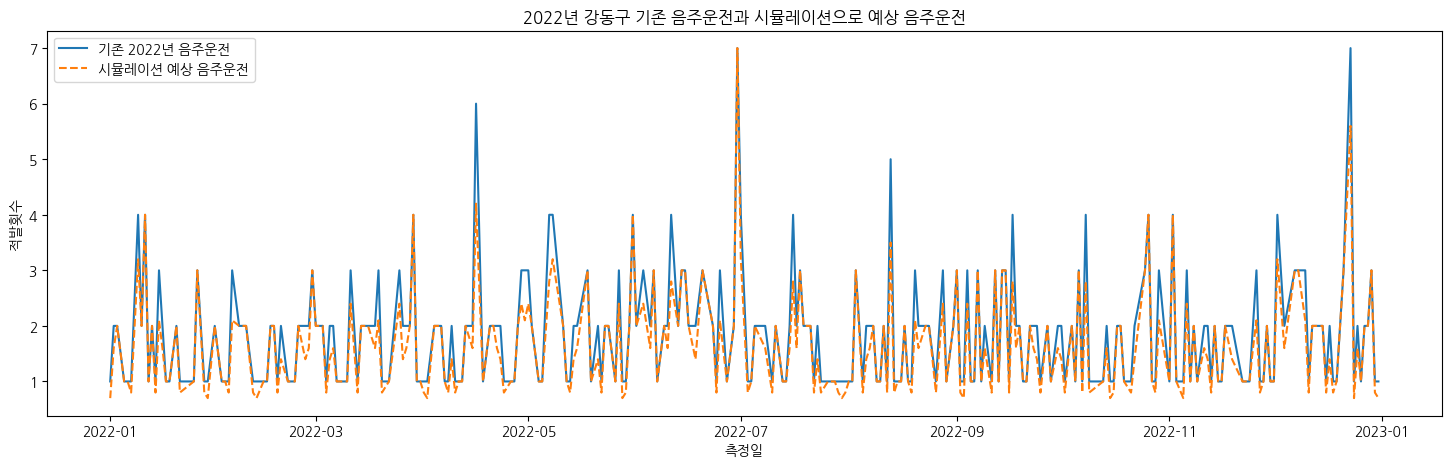

기존 데이터 총 적발 횟수: 524건
평균 시뮬레이션 데이터 총 적발 횟수: 481.67건
평균 총 감소된 적발 횟수: 42.33건


In [ ]:
# 시뮬레이션 결과 저장
simulated_totals = []

# 500번 시뮬레이션 반복
for _ in range(500):
    # 시뮬레이션 진행
    simulated_accidents = daily_accidents.copy()

    # 금요일, 일요일, 토요일 값 감소
    simulated_accidents.loc[fridays | sundays, '적발횟수'] *= np.random.choice([0.8, 1], size=(fridays | sundays).sum(), p=[0.8, 0.2])
    simulated_accidents.loc[saturdays, '적발횟수'] *= np.random.choice([0.7, 1], size=saturdays.sum(), p=[0.6, 0.4])

    # 시뮬레이션 데이터 총 적발 횟수 저장
    simulated_totals.append(simulated_accidents['적발횟수'].sum())

# 평균 시뮬레이션 값 계산
average_simulated_total = np.mean(simulated_totals)

# 시뮬레이션 평균값으로 라인 차트 그리기
average_simulated_accidents = daily_accidents.copy()
average_simulated_accidents.loc[fridays | sundays, '적발횟수'] *= 0.8
average_simulated_accidents.loc[saturdays, '적발횟수'] *= 0.7

# 라인 차트 그리기
plt.figure(figsize=(18, 5))
plt.plot(daily_accidents.index, daily_accidents['적발횟수'], label='기존 2022년 음주운전')
plt.plot(average_simulated_accidents.index, average_simulated_accidents['적발횟수'], label='시뮬레이션 예상 음주운전',linestyle='--')
plt.xlabel('측정일')
plt.ylabel('적발횟수')
plt.title('2022년 강동구 기존 음주운전과 시뮬레이션으로 예상 음주운전', fontsize=12)
plt.legend()
plt.show()

# 기존 데이터 총 적발 횟수
total_accidents_original = daily_accidents['적발횟수'].sum()

# 총 적발 횟수 출력
print(f"기존 데이터 총 적발 횟수: {total_accidents_original}건")
print(f"평균 시뮬레이션 데이터 총 적발 횟수: {average_simulated_total:.2f}건")
print(f"평균 총 감소된 적발 횟수: {total_accidents_original - average_simulated_total:.2f}건")

<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  plt.tight_layout()
<ipython-input-7-e6e8334912db>:31: UserWarning: Glyph 49373 (\N{H

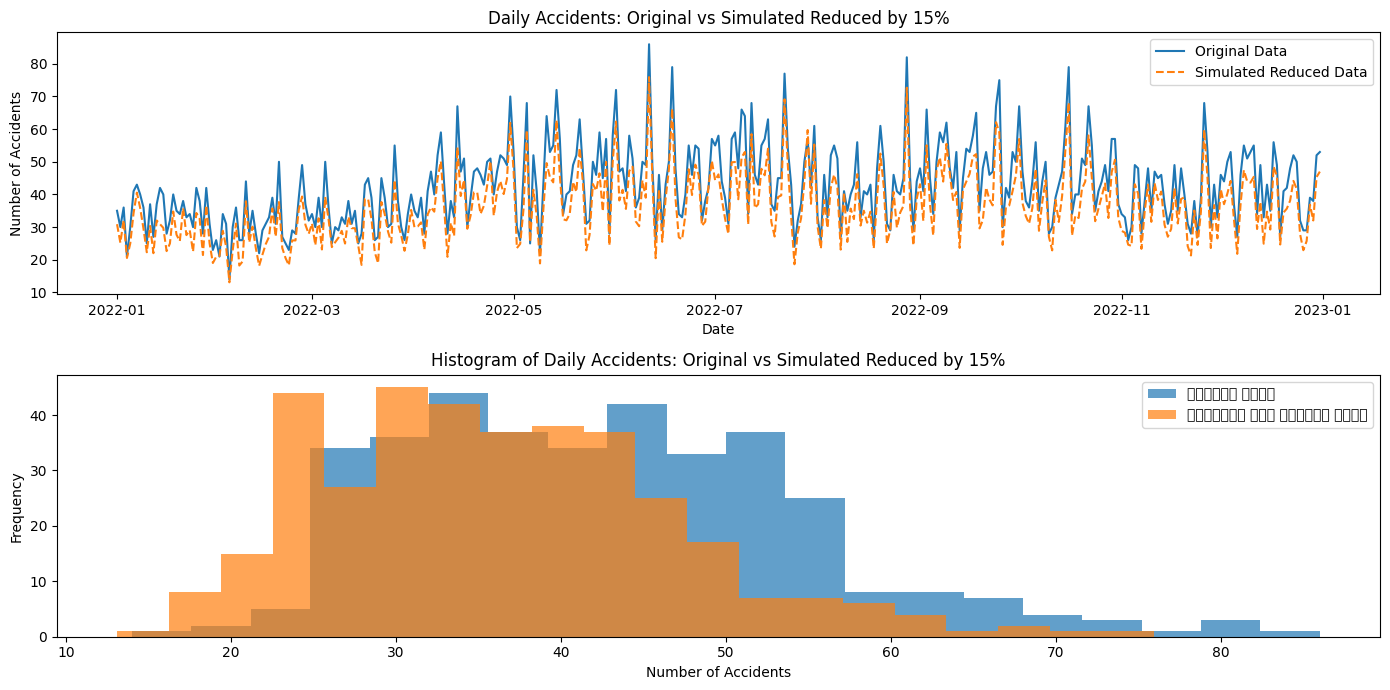

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 시뮬레이션: 각 날짜의 사고 횟수를 평균으로 하여 정규분포를 따르는 값을 생성
np.random.seed(42)  # 재현성을 위해 시드 설정
simulated_reduced_accidents = daily_accidents['적발횟수'].apply(lambda x: max(0, np.random.normal(loc=x * 0.85, scale=np.sqrt(x * 0.15))))

# 시각화
plt.figure(figsize=(14, 7))

# 원래 데이터와 감소한 데이터를 라인차트로 비교
plt.subplot(2, 1, 1)
plt.plot(daily_accidents.index, daily_accidents['적발횟수'], label='Original Data')
plt.plot(daily_accidents.index, simulated_reduced_accidents, label='Simulated Reduced Data', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.title('Daily Accidents: Original vs Simulated Reduced by 15%')
plt.legend()

# 원래 데이터와 감소한 데이터를 히스토그램으로 비교
plt.subplot(2, 1, 2)
plt.hist(daily_accidents['적발횟수'], bins=20, alpha=0.7, label='음주운전사고 발생횟수')
plt.hist(simulated_reduced_accidents, bins=20, alpha=0.7, label='시뮬레이션으로 예측한 음주운전사고 발생횟수')
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Accidents: Original vs Simulated Reduced by 15%')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

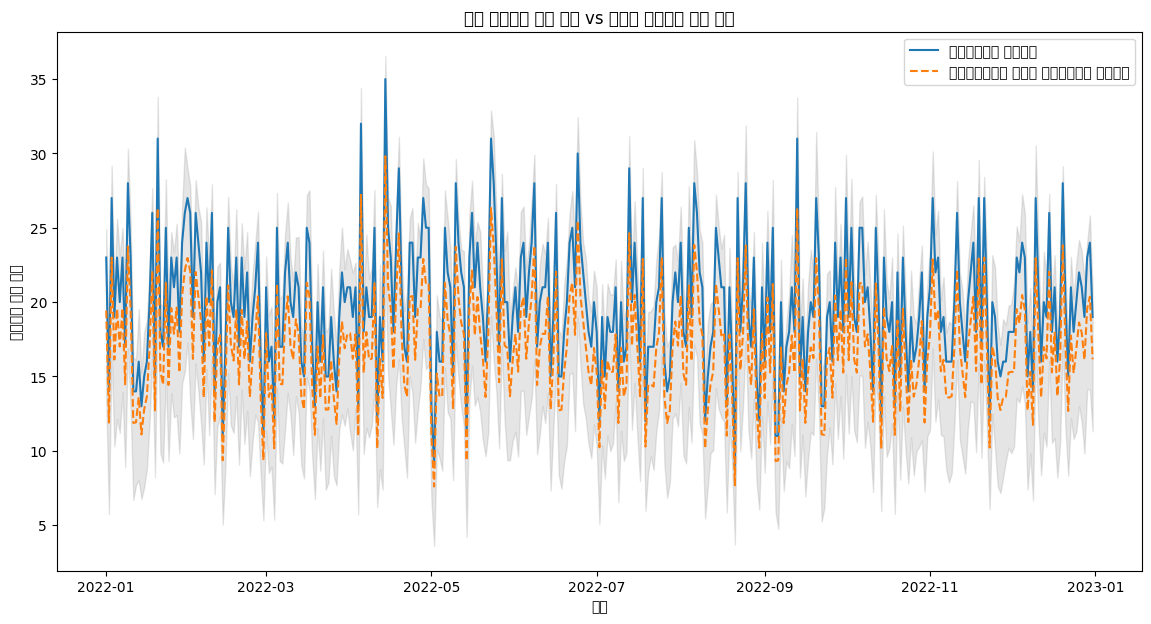

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터프레임 생성 (실제 코드에서는 CSV 파일에서 데이터를 읽어옵니다)
dates_2022 = pd.date_range(start='2022-01-01', end='2022-12-31')
accidents_2022 = np.random.poisson(lam=20, size=len(dates_2022))
data_2022 = pd.DataFrame({'Date': dates_2022, '적발횟수': accidents_2022})
data_2022.set_index('Date', inplace=True)

# 변수 설정
reduction_rate = 0.15  # 사고 횟수 감소 비율
scale_factor = 0.15  # 표준편차에 사용할 스케일 팩터

# 몬테카를로 시뮬레이션 설정
num_simulations = 1000
simulated_accidents = []

# 시뮬레이션 수행
np.random.seed(42)  # 재현성을 위해 시드 설정
for _ in range(num_simulations):
    accidents_2023 = data_2022['적발횟수'].apply(
        lambda x: max(0, np.random.normal(loc=x * (1 - reduction_rate), scale=np.sqrt(x * scale_factor)))
    )
    simulated_accidents.append(accidents_2023.values)

# 시뮬레이션 결과를 데이터프레임으로 변환
simulated_df = pd.DataFrame(simulated_accidents).transpose()
simulated_df.index = data_2022.index

# 시각화
plt.figure(figsize=(14, 7))

# 원래 데이터와 시뮬레이션된 데이터의 평균을 라인차트로 비교
plt.plot(data_2022.index, data_2022['적발횟수'], label='음주운전사고 발생횟수')
plt.plot(data_2022.index, simulated_df.mean(axis=1), label='시뮬레이션으로 예측한 음주운전사고 발생횟수', linestyle='--')

# 시뮬레이션 결과의 분포를 박스플롯으로 시각화
plt.fill_between(data_2022.index, simulated_df.min(axis=1), simulated_df.max(axis=1), color='gray', alpha=0.2)
plt.xlabel('날짜')
plt.ylabel('음주운전 사고 건수')
plt.title('기존 음주운전 사고 발생 vs 예측된 음주운전 사고 발생')
plt.legend()
plt.show()


총 사고 감소 횟수: 2317.0911648927677
감소하는 사고의 총 경제적 효과: 11,585,455,824.46원


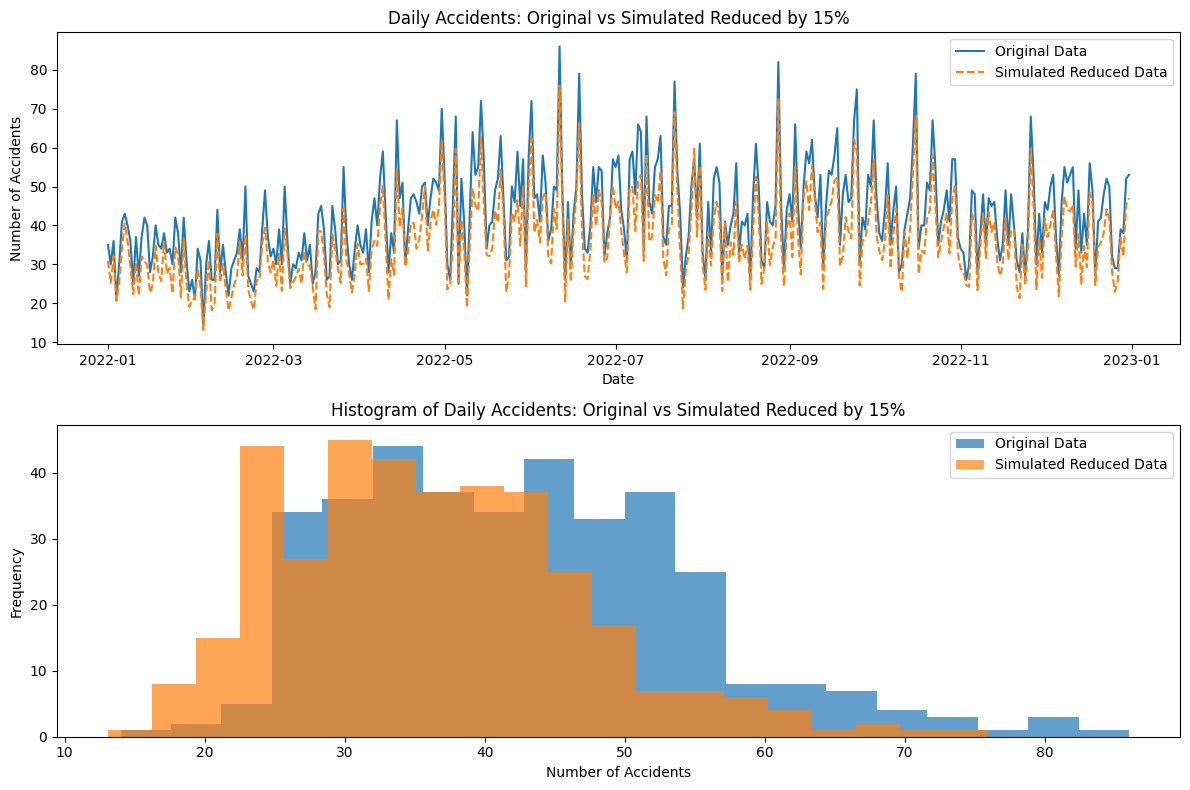

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 시뮬레이션: 각 날짜의 사고 횟수를 평균으로 하여 정규분포를 따르는 값을 생성
np.random.seed(42)  # 재현성을 위해 시드 설정
simulated_reduced_accidents = daily_accidents['적발횟수'].apply(lambda x: max(0, np.random.normal(loc=x * 0.85, scale=np.sqrt(x * 0.15))))

# 사고 감소에 따른 경제적 효과 계산
C = 5000000  # 한 사고당 평균 경제적 비용
reduction_in_accidents = daily_accidents['적발횟수'] - simulated_reduced_accidents
economic_effect = reduction_in_accidents.sum() * C

# 결과 출력
print(f"총 사고 감소 횟수: {reduction_in_accidents.sum()}")
print(f"감소하는 사고의 총 경제적 효과: {economic_effect:,.2f}원")

# 시각화
plt.figure(figsize=(12, 8))

# 원래 데이터와 감소한 데이터를 라인차트로 비교
plt.subplot(2, 1, 1)
plt.plot(daily_accidents.index, daily_accidents['적발횟수'], label='Original Data')
plt.plot(daily_accidents.index, simulated_reduced_accidents, label='Simulated Reduced Data', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.title('Daily Accidents: Original vs Simulated Reduced by 15%')
plt.legend()

# 원래 데이터와 감소한 데이터를 히스토그램으로 비교
plt.subplot(2, 1, 2)
plt.hist(daily_accidents['적발횟수'], bins=20, alpha=0.7, label='Original Data')
plt.hist(simulated_reduced_accidents, bins=20, alpha=0.7, label='Simulated Reduced Data')
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Accidents: Original vs Simulated Reduced by 15%')
plt.legend()

plt.tight_layout()
plt.show()


# 시뮬


사고 처리에 드는 행정 비용
도로 및 인프라 수리 비용

사상자수 감소:

중상자 및 사망자 감소로 인한 비용 절감
사고당 평균 경제적 비용을 5,000,000원으로 설정하고, 추가적으로 사상자 감소로 인한 비용 절감을 추정해보겠습니다. 예를 들어, 한 사고당 평균적으로 0.1명의 사상자가 발생한다고 가정할 수 있습니다. 한 사상자의 경제적 비용을 100,000,000원으로 가정하면, 사고 감소에 따른 사상자 감소 효과를 계산할 수 있습니다.

총 사고 감소 횟수: 2317.0911648927677
감소하는 사고의 총 경제적 효과: ₩11,585,455,824
감소하는 사상자의 총 경제적 효과: ₩23,170,911,649
총 경제적 효과: ₩34,756,367,473


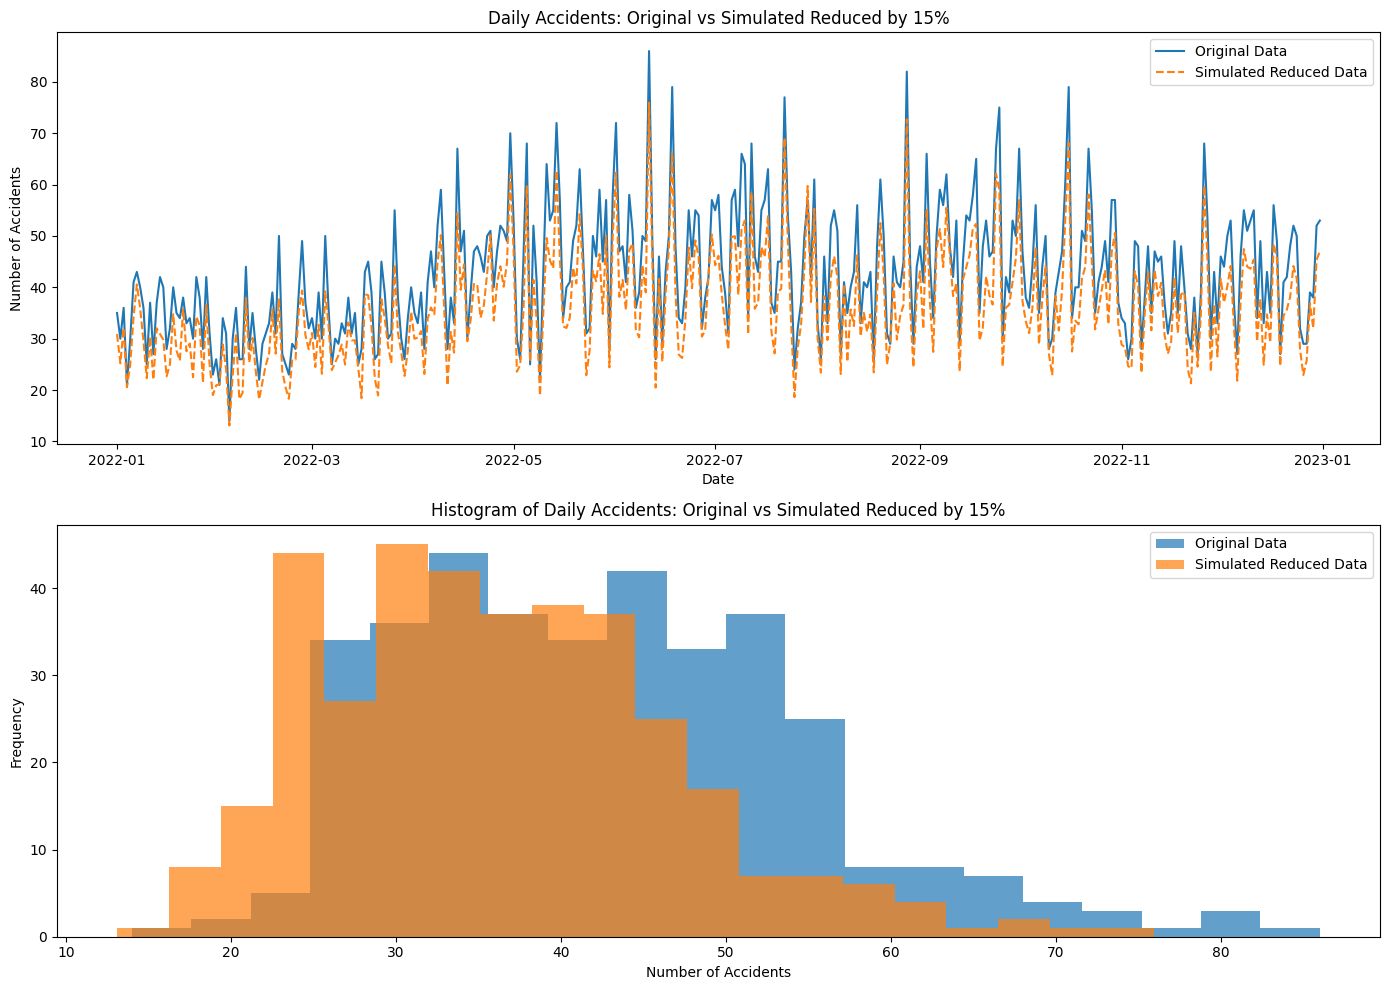

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV 파일에서 데이터 로드
#daily_accidents = pd.read_csv('daily_accidents.csv', parse_dates=['측정일'], index_col='측정일')

# 시뮬레이션: 각 날짜의 사고 횟수를 평균으로 하여 정규분포를 따르는 값을 생성
np.random.seed(42)  # 재현성을 위해 시드 설정
simulated_reduced_accidents = daily_accidents['적발횟수'].apply(lambda x: max(0, np.random.normal(loc=x * 0.85, scale=np.sqrt(x * 0.15))))

# 사고 감소에 따른 경제적 효과 계산
C = 5000000  # 한 사고당 평균 경제적 비용 (5,000,000원)
reduction_in_accidents = daily_accidents['적발횟수'] - simulated_reduced_accidents
economic_effect = reduction_in_accidents.sum() * C

# 사상자 감소에 따른 추가 경제적 효과 계산
average_casualties_per_accident = 0.1  # 사고당 평균 사상자 수
cost_per_casualty = 100000000  # 한 사상자당 경제적 비용 (100,000,000원)
reduction_in_casualties = reduction_in_accidents.sum() * average_casualties_per_accident
casualty_reduction_effect = reduction_in_casualties * cost_per_casualty

# 총 경제적 효과
total_economic_effect = economic_effect + casualty_reduction_effect

# 결과 출력
print(f"총 사고 감소 횟수: {reduction_in_accidents.sum()}")
print(f"감소하는 사고의 총 경제적 효과: ₩{economic_effect:,.0f}")
print(f"감소하는 사상자의 총 경제적 효과: ₩{casualty_reduction_effect:,.0f}")
print(f"총 경제적 효과: ₩{total_economic_effect:,.0f}")

# 시각화
plt.figure(figsize=(14, 10))

# 원래 데이터와 감소한 데이터를 라인차트로 비교
plt.subplot(2, 1, 1)
plt.plot(daily_accidents.index, daily_accidents['적발횟수'], label='Original Data')
plt.plot(daily_accidents.index, simulated_reduced_accidents, label='Simulated Reduced Data', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.title('Daily Accidents: Original vs Simulated Reduced by 15%')
plt.legend()

# 원래 데이터와 감소한 데이터를 히스토그램으로 비교
plt.subplot(2, 1, 2)
plt.hist(daily_accidents['적발횟수'], bins=20, alpha=0.7, label='Original Data')
plt.hist(simulated_reduced_accidents, bins=20, alpha=0.7, label='Simulated Reduced Data')
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Accidents: Original vs Simulated Reduced by 15%')
plt.legend()

plt.tight_layout()
plt.show()
